## Data Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt



In [18]:
Pepsi = pd.read_csv('PEP.csv',header=0,index_col=0,parse_dates=True)

In [26]:
Pepsi_Price = Pepsi.loc[:,'Adj Close'] # we only want to estimate the closing price

In [27]:
Pepsi_Price.head()

Date
2020-01-21    137.843002
2020-01-22    139.319946
2020-01-23    139.582306
2020-01-24    138.872986
2020-01-27    138.115067
Name: Adj Close, dtype: float64

<AxesSubplot:xlabel='Date'>

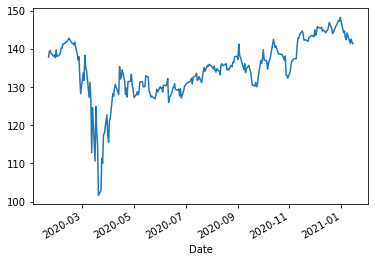

In [28]:
Pepsi_Price.plot() 

In [30]:
Coke = pd.read_csv('KO.csv',header=0,index_col=0,parse_dates=True)

In [34]:
Coke_Price = Coke.loc[:,'Adj Close']

<AxesSubplot:xlabel='Date'>

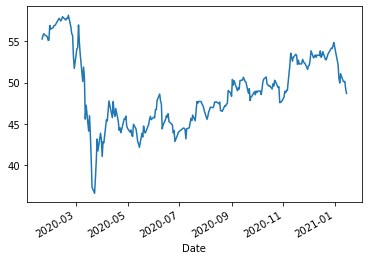

In [35]:
Coke_Price.plot()

In [47]:
New_Price = pd.concat([Coke_Price,Pepsi_Price],axis=1)

In [48]:
New_Price

,Adj Close,Adj Close
Date,,
2020-01-21,55.278336,137.843002
2020-01-22,55.703781,139.319946
2020-01-23,55.916504,139.582306
2020-01-24,55.771458,138.872986
2020-01-27,55.578079,138.115067
...,...,...
2021-01-11,50.200001,142.089996
2021-01-12,50.110001,141.429993
2021-01-13,50.160000,142.589996


In [50]:
New_Price.columns = ['Coke','Pepsi']
New_Price

,Coke,Pepsi
Date,,
2020-01-21,55.278336,137.843002
2020-01-22,55.703781,139.319946
2020-01-23,55.916504,139.582306
2020-01-24,55.771458,138.872986
2020-01-27,55.578079,138.115067
...,...,...
2021-01-11,50.200001,142.089996
2021-01-12,50.110001,141.429993
2021-01-13,50.160000,142.589996


<AxesSubplot:xlabel='Date'>

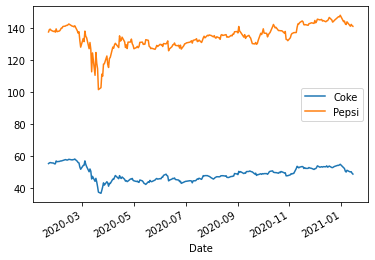

In [51]:
New_Price.plot() # Now we got two asset's closing price side by side, with dates labelled
#However it is not yet stationary

In [53]:
import numpy as np

In [55]:
test = np.log(Coke_Price).diff(1)

In [60]:
test = test.dropna()

In [61]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

#apply adf test on the series
adf_test(test)

Results of Dickey-Fuller Test:
Test Statistic                  -4.686520
p-value                          0.000089
#Lags Used                      11.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


In [62]:
# Since the above result's Test Statistic is now smaller than Critical Value, we are confident it has no unit root, thus stationary
Coke_diffed = test

In [63]:
test2 = np.log(Pepsi_Price).diff(1)

In [64]:
test2 = test2.dropna()

In [65]:
adf_test(test2)

Results of Dickey-Fuller Test:
Test Statistic                  -4.680826
p-value                          0.000091
#Lags Used                      11.000000
Number of Observations Used    238.000000
Critical Value (1%)             -3.458128
Critical Value (5%)             -2.873762
Critical Value (10%)            -2.573283
dtype: float64


In [66]:
Pepsi_diffed = test2 

In [97]:
Coke_Original = np.log(Coke_Price)[0]
Pepsi_Original = np.log(Pepsi_Price)[0]
#These comes in handy when we come back for original transformation

<AxesSubplot:xlabel='Date'>

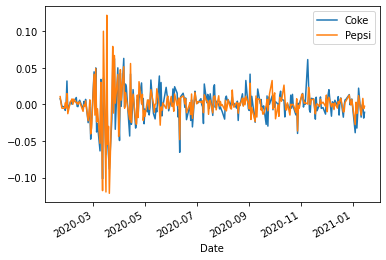

In [75]:
Preprocess_Price = pd.concat([Coke_diffed,Pepsi_diffed],axis=1)
Preprocess_Price.columns = ['Coke','Pepsi']
Preprocess_Price.plot()

## Model training and Predicting

In [76]:
#creating the train and validation set
train = Preprocess_Price[:int(0.8*(len(Preprocess_Price)))]
valid = Preprocess_Price[int(0.8*(len(Preprocess_Price))):]

#fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train)
model_fit = model.fit()

# make prediction on validation
prediction = model_fit.forecast(model_fit.y, steps=len(valid))

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/wrapper.py:34: FutureWarning: y is a deprecated alias for endog, will be removed in version 0.11.0
  obj = getattr(results, attr)


In [82]:
model = VAR(endog=Preprocess_Price)
model_fit = model.fit()
yhat = model_fit.forecast(model_fit.y, steps=2) # Predict two days in advance
print(yhat)

[[-0.00125962 -0.00091245]
 [-0.00040503  0.0004386 ]]


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


## Adding prediction back to our chart

In [171]:
yhat2 = pd.concat([pd.Series(yhat[0]),pd.Series(yhat[1])],axis=1)
yhat2.columns = ['Coke','Pepsi']
yhat2 = yhat2.rename(index={0:'2021-01-19',1:'2021-01-20'} )

In [172]:
preprocess = pd.concat([Preprocess_Price,yhat2],axis=0)

In [173]:
preprocess = preprocess.cumsum()

In [174]:
Coke_Now = np.exp(preprocess['Coke'] + Coke_Original)
Pepsi_Now = np.exp(preprocess['Pepsi']+ Pepsi_Original)

In [175]:
A= pd.concat([Coke_Now,Pepsi_Now],axis=1)

In [176]:
A.index = pd.to_datetime(A.index)

In [177]:
Final_V = A

In [178]:
Part1 = Final_V.loc['2020-01-22':'2021-01-15',:]
Part1

,Coke,Pepsi
2020-01-22,55.703781,139.319946
2020-01-23,55.916504,139.582306
2020-01-24,55.771458,138.872986
2020-01-27,55.578079,138.115067
2020-01-28,55.123631,138.406570
...,...,...
2021-01-11,50.200001,142.089996
2021-01-12,50.110001,141.429993
2021-01-13,50.160000,142.589996
2021-01-14,49.230000,141.759995


In [179]:
Part2 = Final_V.loc['2021-01-19':'2021-01-20',:]
Part2

,Coke,Pepsi
2021-01-19,48.638696,141.332744
2021-01-20,48.594336,141.394746


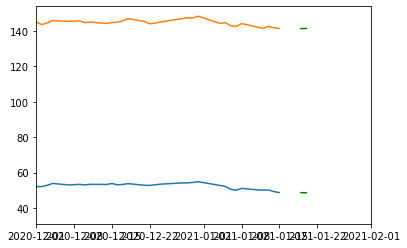

In [189]:
plt.plot(Part1)
plt.plot(Part2,'g')
plt.xlim(['2020-12', '2021-02'])
plt.show()

### The work needs to do some more visualization in order to better represent my predictions.
Furthermore, needs more fine tuning for better accuracy if to predict longer term forecasts.